In [1]:
import matplotlib.pyplot as plt
import networkx as nx
import pandas as pd
import numpy as np
import scipy.io
import pickle

### Loading Dataset:

In [2]:
data = pd.read_csv('./raw/kubernetes.csv')

### List of Pull Requests:

In [3]:
pr_id_list = list(data['pr_id'].unique())

### Get Number of Reviews for a Pull Request:

In [4]:
def get_num_reviews(pr_id, data):
    
    reviewer_list = {}
    pr_df = data.loc[data.pr_id == pr_id, :]
    
    commenter_list = list(pr_df.commenter_id.values)
    commenter_set = set(commenter_list)
    
    head_commiter_set = set(pr_df.head_commit_committer_id.values)
    head_author_set = set(pr_df.head_commit_author_id.values)
    pr_owner_set = (head_author_set | head_commiter_set) & commenter_set
    reviewer_set = commenter_set - pr_owner_set
    
    buf_list = []
    for c in commenter_list:
        if c not in pr_owner_set:
            buf_list += [c]
    
    commenter_freq = {}
    for reviewer in buf_list:
        if reviewer not in commenter_freq:
            commenter_freq.update({reviewer: 1})
        else:
            commenter_freq[reviewer] += 1

    return commenter_freq

### Feature 1: Number of comments made by Reviewer r on PullRequest p

In [5]:
def ncomments_on_pr_by_reviewer(pr_id, reviewer_id, data):

    res = get_num_reviews(pr_id, data)
    
    if reviewer_id in res.keys():
        return res[reviewer_id]
    else:
        return 0

### Feature 2: Number of total Pull-Requests submitted by Reviewer r to the repository

In [6]:
def npullreq_on_repo_by_reviewer(reviewer, data):
    df = set(data[data.commenter_id == reviewer]['head_repo_id'])
    return len(df)

### Load Entities and Entity Metadata:

In [7]:
entities = None
with open('./cache/arr/entities.pkl', 'rb') as file:
    entities = pickle.load(file)

In [8]:
entity_metadata = None
with open('./cache/dicts/entity_metadata.pkl', 'rb') as file:
    entity_metadata = pickle.load(file)

### Loading Reviewers:

In [9]:
reviewers = None
with open('./cache/arr/reviewers.pkl', 'rb') as file:
    reviewers = pickle.load(file)

### Reviewers Count for a Pull Request:

In [10]:
reviewer_count = {}
for pr_id in pr_id_list:
    reviewer_count[pr_id] = get_num_reviews(pr_id,data)

In [11]:
total_pr_reviewed = {}

for reviewer in reviewers:
    for pr_id in set(pr_id_list):
        if pr_id in reviewer_count.keys():
            if reviewer in list(reviewer_count[pr_id].keys()):

                if reviewer not in total_pr_reviewed.keys():

                    total_pr_reviewed.update({
                        reviewer: {
                            'pr_list': [pr_id], 
                            'total_counts': 1
                        }
                    })

                else:

                    total_pr_reviewed[reviewer]['pr_list'] += [pr_id]
                    total_pr_reviewed[reviewer]['total_counts'] += 1

In [12]:
total_pr_count = {}

for (rev, pr) in total_pr_reviewed.items():
    total_pr_count[rev] = len(set(pr))

### Conversion Utilities:

In [13]:
pr_id_2_matrix_row_id = {}
matrix_row_id_2_pr_id = {}

counter = 0
for pr_id in sorted(pr_id_list):
    pr_id_2_matrix_row_id.update({pr_id: counter})
    matrix_row_id_2_pr_id.update({counter: pr_id})
    counter += 1

In [14]:
reviewer_id_2_matrix_col_id = {}
matrix_col_id_2_reviewer_id = {}

counter = 0
for reviewer in sorted(reviewers):
    reviewer_id_2_matrix_col_id.update({reviewer: counter})
    matrix_col_id_2_reviewer_id.update({counter: reviewer})
    counter += 1

### SRW Graph:

In [15]:
srw_psi_matrix = np.zeros(
    shape=(
        len(pr_id_2_matrix_row_id.keys()), 
        len(reviewer_id_2_matrix_col_id.keys()), 
        1
    ), 
    dtype=np.object
)

In [16]:
for pr_id in pr_id_list:
    res = get_num_reviews(pr_id, data)
    for reviewer in reviewers:
        
        if reviewer in res.keys():
            # Feature present or not:
            # srw_psi_matrix[pr_id_2_matrix_row_id[pr_id]][reviewer_id_2_matrix_col_id[reviewer]][0] = 1
            
            # Actual Features:
            srw_psi_matrix[pr_id_2_matrix_row_id[pr_id]][reviewer_id_2_matrix_col_id[reviewer]][0] = res[reviewer]
        else:
            srw_psi_matrix[pr_id_2_matrix_row_id[pr_id]][reviewer_id_2_matrix_col_id[reviewer]][0] = 0

In [17]:
export_matrix = False

if export_matrix == True:
    np.save('srw.npy', srw_psi_matrix)
    # scipy.io.savemat('matrix.mat', {'srw_mat': srw_psi_matrix})

### Personalized Random Walk:

In [18]:
graph = nx.Graph()

In [19]:
for r in reviewers:
    for node in total_pr_reviewed[r]['pr_list']:
        graph.add_edge(r, node)

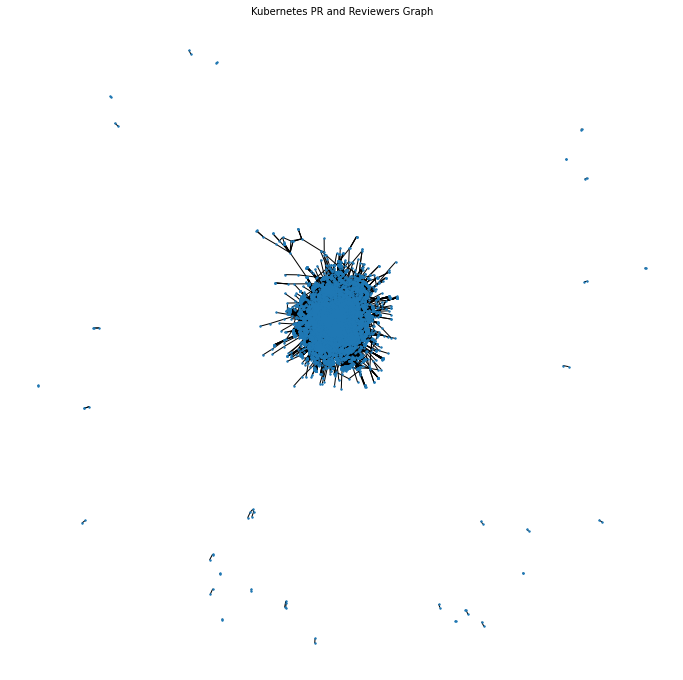

In [20]:
fig = plt.figure(figsize=(12,12))
ax = plt.subplot(111)
ax.set_title('Kubernetes PR and Reviewers Graph', fontsize=10)
pos = nx.spring_layout(graph)
nx.draw(graph, pos, node_size=2, width=1)
plt.savefig('Github_Graph.svg', format='svg', dpi=1200)